### Import Libraries

Note: code borrowed from https://www.kaggle.com/code/alexj21/pytorch-eda-unet-from-scratch-finetuning

In [8]:
%matplotlib inline
import os

import cv2
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torchmetrics.classification import Dice
from torchvision import transforms
from torchmetrics.classification import BinaryConfusionMatrix
from torchmetrics import JaccardIndex
import torchvision.models.segmentation

from tqdm import tqdm

from utilities import AITEXPatchedSegmentation
from model_architectures import BinaryClassifier, MiniUNet


### Load Segmentation Data

In [2]:
# Define paths
root = os.path.abspath(os.path.join(os.getcwd(), ".."))
model_dir = os.path.join(root, "models")
data_dir = os.path.join(root, "data")
aitex_dir = os.path.join(data_dir, "aitex")

# Load dataset with transforms and split
transform = transforms.Compose([])
data = AITEXPatchedSegmentation(aitex_dir, transform=transform)#, normal_only=True)
num_samples = len(data)
train_samples = int(num_samples * 0.95)
val_samples = num_samples - train_samples
train, val = random_split(data, [train_samples, val_samples])

bs = 4
train_loader = DataLoader(train, batch_size=bs)
val_loader = DataLoader(val, batch_size=bs, shuffle=False)


### Define Helper Functions

In [3]:
def compute_metrics(pred, true, batch_size=16, threshold=0.5):
    pred = pred.view(batch_size, -1)
    true = true.view(batch_size, -1)
    
    pred = (pred > threshold).float()
    true = (true > threshold).float()
    
    pred_sum = pred.sum(-1)
    true_sum = true.sum(-1)
    
    neg_index = torch.nonzero(true_sum == 0)
    pos_index = torch.nonzero(true_sum >= 1)
    
    dice_neg = (pred_sum == 0).float()
    dice_pos = 2 * ((pred * true).sum(-1)) / ((pred + true).sum(-1))
    
    dice_neg = dice_neg[neg_index]
    dice_pos = dice_pos[pos_index]
    
    dice = torch.cat([dice_pos, dice_neg])
    jaccard = dice / (2 - dice)
    
    return dice, jaccard
    
class metrics:
    def __init__(self, batch_size=16, threshold=0.5):
        self.threshold = threshold
        self.batchsize = batch_size
        self.dice = []
        self.jaccard = []
    def collect(self, pred, true):
        pred = torch.sigmoid(pred)
        dice, jaccard = compute_metrics(pred, true, batch_size=self.batchsize, threshold=self.threshold)
        self.dice.extend(dice)
        self.jaccard.extend(jaccard)
    def get(self):
        dice = np.nanmean(self.dice)
        jaccard = np.nanmean(self.jaccard)
        return dice, jaccard

### Define Loss Functions

In [4]:
class BCEJaccardWithLogitsLoss(nn.Module):
    def __init__(self, jaccard_weight=1, smooth=1):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.jaccard_weight = jaccard_weight
        self.smooth = smooth

    def forward(self, outputs, targets):
        if outputs.size() != targets.size():
            raise ValueError("size mismatch, {} != {}".format(outputs.size(), targets.size()))
            
        loss = self.bce(outputs, targets)

        if self.jaccard_weight:
            targets = (targets == 1.0).float()
            targets = targets.view(-1)
            outputs = torch.sigmoid(outputs)
            outputs = outputs.view(-1)

            intersection = (targets * outputs).sum()
            union = outputs.sum() + targets.sum() - intersection

            loss -= self.jaccard_weight * torch.log((intersection + self.smooth ) / (union + self.smooth )) # try with 1-dice
        return loss

class BCEDiceWithLogitsLoss(nn.Module):
    def __init__(self, dice_weight=1, smooth=1):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice_weight = dice_weight
        self.smooth = smooth
        
    def __call__(self, outputs, targets):
        if outputs.size() != targets.size():
            raise ValueError("size mismatch, {} != {}".format(outputs.size(), targets.size()))
            
        loss = self.bce(outputs, targets)

        targets = (targets == 1.0).float()
        targets = targets.view(-1)
        outputs = F.sigmoid(outputs)
        outputs = outputs.view(-1)

        intersection = (outputs * targets).sum()
        dice = 2.0 * (intersection + self.smooth)  / (targets.sum() + outputs.sum() + self.smooth)
        
        loss -= self.dice_weight * torch.log(dice) # try with 1- dice

        return loss
    
class FocalWithLogitsLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.alpha = alpha
        self.gamma = gamma
        
    def __call__(self, outputs, targets):
        if outputs.size() != targets.size():
            raise ValueError("size mismatch, {} != {}".format(outputs.size(), targets.size()))
            
        loss = self.bce(outputs, targets)

        targets = (targets == 1.0).float()
        targets = targets.view(-1)
        outputs = torch.sigmoid(outputs)
        outputs = outputs.view(-1)
        outputs = torch.where(targets == 1, outputs, 1 - outputs)

        focal = self.alpha * (1 - outputs) ** (self.gamma)
        loss *= focal.mean()

        return loss

def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

### Define Improved UNet Model Architecture

In [5]:
"""Improved U-Net""" 
# Implementation from https://github.com/timctho/unet-pytorch/
class IUNet_down_block(torch.nn.Module):
    def __init__(self, input_channel, output_channel, down_size):
        super(IUNet_down_block, self).__init__()
        self.conv1 = torch.nn.Conv2d(input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channel)
        self.max_pool = torch.nn.MaxPool2d(2, 2)
        self.relu = torch.nn.ReLU()
        self.down_size = down_size

    def forward(self, x):
        if self.down_size:
            x = self.max_pool(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x

class IUNet_up_block(torch.nn.Module):
    def __init__(self, prev_channel, input_channel, output_channel):
        super(IUNet_up_block, self).__init__()
        self.up_sampling = torch.nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv1 = torch.nn.Conv2d(prev_channel + input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channel)
        self.relu = torch.nn.ReLU()

    def forward(self, prev_feature_map, x):
        x = self.up_sampling(x)
        x = torch.cat((x, prev_feature_map), dim=1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x


class IUNet(torch.nn.Module):
    def __init__(self):
        super(IUNet, self).__init__()

        self.down_block1 = IUNet_down_block(3, 16, False)
        self.down_block2 = IUNet_down_block(16, 32, True)
        self.down_block3 = IUNet_down_block(32, 64, True)
        self.down_block4 = IUNet_down_block(64, 128, True)
        self.down_block5 = IUNet_down_block(128, 256, True)
        self.down_block6 = IUNet_down_block(256, 512, True)
        self.down_block7 = IUNet_down_block(512, 1024, True)

        self.mid_conv1 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(1024)
        self.mid_conv2 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(1024)
        self.mid_conv3 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(1024)

        self.up_block1 = IUNet_up_block(512, 1024, 512)
        self.up_block2 = IUNet_up_block(256, 512, 256)
        self.up_block3 = IUNet_up_block(128, 256, 128)
        self.up_block4 = IUNet_up_block(64, 128, 64)
        self.up_block5 = IUNet_up_block(32, 64, 32)
        self.up_block6 = IUNet_up_block(16, 32, 16)

        self.last_conv1 = torch.nn.Conv2d(16, 16, 3, padding=1)
        self.last_bn = torch.nn.BatchNorm2d(16)
        self.last_conv2 = torch.nn.Conv2d(16, 1, 1, padding=0)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        self.x1 = self.down_block1(x)
        self.x2 = self.down_block2(self.x1)
        self.x3 = self.down_block3(self.x2)
        self.x4 = self.down_block4(self.x3)
        self.x5 = self.down_block5(self.x4)
        self.x6 = self.down_block6(self.x5)
        self.x7 = self.down_block7(self.x6)
        self.x7 = self.relu(self.bn1(self.mid_conv1(self.x7)))
        self.x7 = self.relu(self.bn2(self.mid_conv2(self.x7)))
        self.x7 = self.relu(self.bn3(self.mid_conv3(self.x7)))
        x = self.up_block1(self.x6, self.x7)
        x = self.up_block2(self.x5, x)
        x = self.up_block3(self.x4, x)
        x = self.up_block4(self.x3, x)
        x = self.up_block5(self.x2, x)
        x = self.up_block6(self.x1, x)
        x = self.relu(self.last_bn(self.last_conv1(x)))
        x = self.last_conv2(x)
        return x
        
        
"""Original U-Net"""
class UNet_down_block(torch.nn.Module):
    def __init__(self, input_channel, output_channel, down_size):
        super(UNet_down_block, self).__init__()
        self.conv1 = torch.nn.Conv2d(input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.max_pool = torch.nn.MaxPool2d(2, 2)
        self.relu = torch.nn.ReLU()
        self.down_size = down_size

    def forward(self, x):
        if self.down_size:
            x = self.max_pool(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class UNet_up_block(torch.nn.Module):
    def __init__(self, prev_channel, input_channel, output_channel):
        super(UNet_up_block, self).__init__()
        self.up_sampling = torch.nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv1 = torch.nn.Conv2d(prev_channel + input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.relu = torch.nn.ReLU()

    def forward(self, prev_feature_map, x):
        x = self.up_sampling(x)
        x = torch.cat((x, prev_feature_map), dim=1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x


class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.down_block1 = UNet_down_block(1, 64, False)
        self.down_block2 = UNet_down_block(64, 128, True)
        self.down_block3 = UNet_down_block(128, 256, True)
        self.down_block4 = UNet_down_block(256, 512, True)
        self.down_block5 = UNet_down_block(512, 1024, True)

        self.up_block1 = UNet_up_block(512, 1024, 512)
        self.up_block2 = UNet_up_block(256, 512, 256)
        self.up_block3 = UNet_up_block(128, 256, 128)
        self.up_block4 = UNet_up_block(64, 128, 64)

        self.last_conv = torch.nn.Conv2d(64, 1, 1, padding=0)

    def forward(self, x):
        self.x1 = self.down_block1(x)
        self.x2 = self.down_block2(self.x1)
        self.x3 = self.down_block3(self.x2)
        self.x4 = self.down_block4(self.x3)
        self.x5 = self.down_block5(self.x4)
        x = self.up_block1(self.x4, self.x5)
        x = self.up_block2(self.x3, x)
        x = self.up_block3(self.x2, x)
        x = self.up_block4(self.x1, x)
        x = self.last_conv(x)
        return x

### Instantiate Model

In [7]:
device = "cuda"
model = UNet()
model.to(device)

lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)
criterion = MixedLoss(10, 2)

In [46]:
report_each = 5
n_epochs = 100
for epoch in range(1, n_epochs + 1):
    model.train()
    losses = []

    mean_loss = 0
    with tqdm(train_loader, unit="batch", ascii=' >=') as tepoch:
        for inputs, targets in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model.forward(inputs)
            loss = criterion(outputs, targets)
            batch_size = inputs.size(0)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            mean_loss = np.mean(losses[-report_each:])
            tepoch.set_postfix(loss='{:.5f}'.format(mean_loss))


Epoch 100: 100%|==========| 44/44 [00:06<00:00,  6.77batch/s, loss=0.37252]


In [66]:
# torch.save(model.state_dict(), os.path.join(model_dir, "unet_seg_50epoch.pt"))
torch.save(model.state_dict(), os.path.join(model_dir, "unet_seg_200epoch.pt"))

In [6]:
device = "cuda"
model_path = os.path.join(model_dir, "unet_seg_200epoch.pt")
model = UNet()
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()


UNet(
  (down_block1): UNet_down_block(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (down_block2): UNet_down_block(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (down_block3

### Validate Results

In [50]:
# train data
jaccard = JaccardIndex(task = "binary")

model.eval()
images = []
gt = []
predictions = []
for inputs, targets in train_loader:
    outputs = model(inputs.to(device))
    images.append(inputs.cpu().detach().numpy())
    gt.append(targets.cpu().detach().numpy())
    predictions.append(outputs.cpu().detach().numpy())

        # calculate iou
    for idx in range(0, len(targets)):
        pred = outputs[idx].reshape(256, 256).cpu().detach().numpy()
        amin = np.amin(pred)
        amax = np.amax(pred)
        pred = (pred - amin) / (amax - amin)
        _, thresh = cv2.threshold(pred, 0.75, 1, cv2.THRESH_BINARY)

        og_mask = targets[idx].reshape(1, 256, 256).cpu()
        iou.append(jaccard(
            torch.Tensor(thresh).reshape(1, 256, 256), 
            torch.Tensor(og_mask).reshape(1, 256, 256)).item()
            )
        
print("Mean IOU: ", np.mean(iou))

Mean IOU:  0.3801773455128667


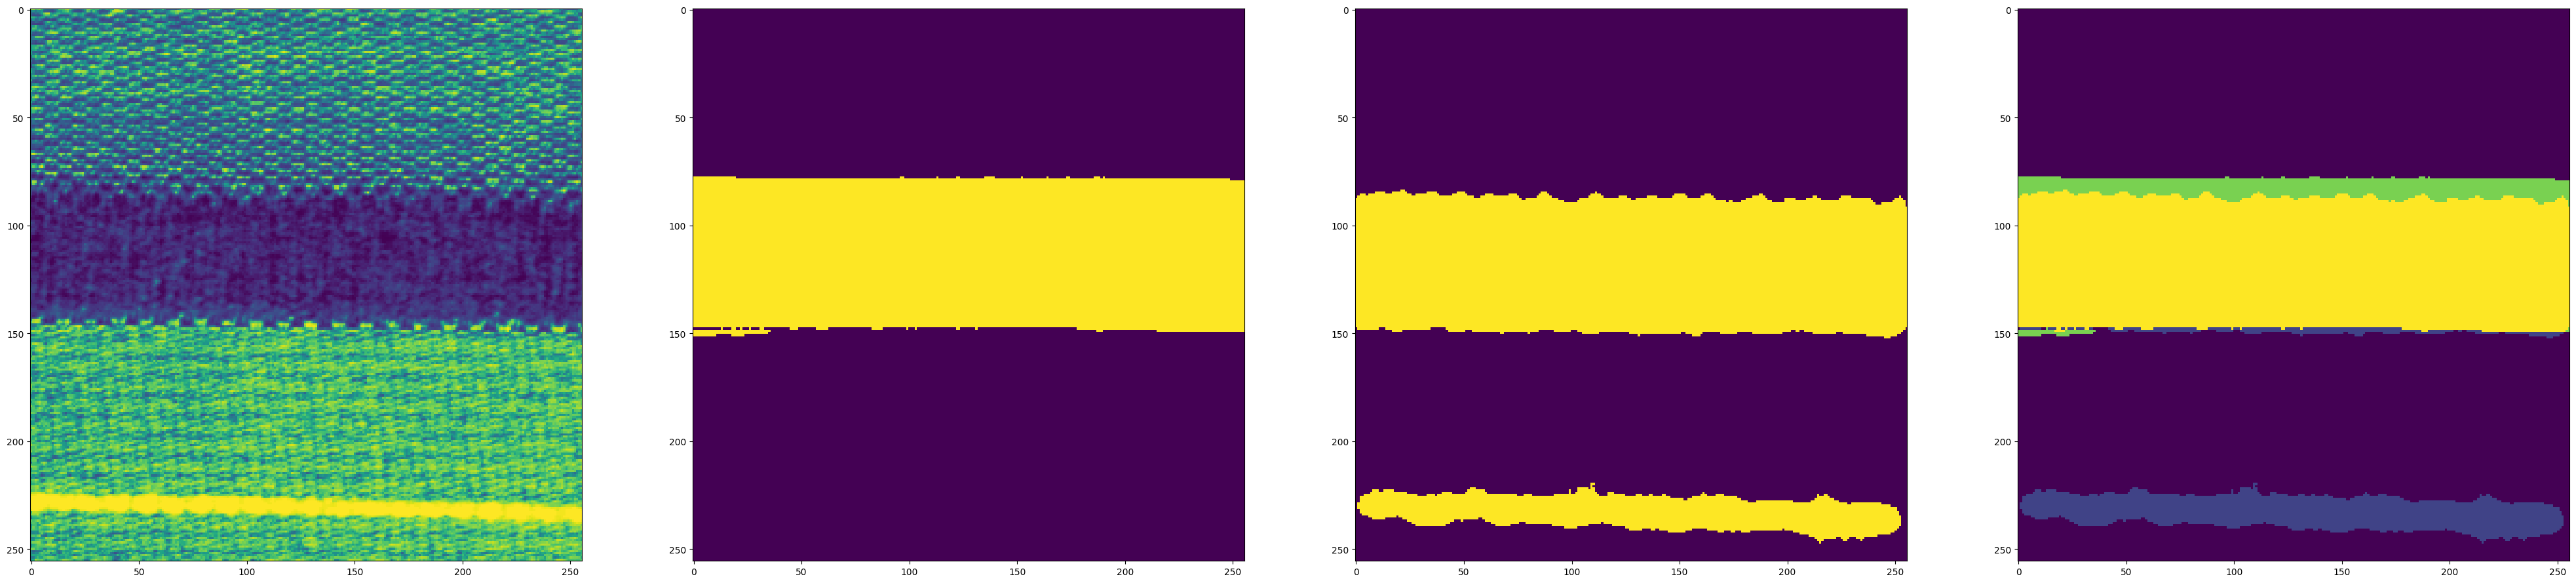

In [51]:
bn = 1
inputs = images[bn]
targets = gt[bn]
outputs = predictions[bn]

idx = 1
img = inputs[idx].reshape(256, 256)
og_mask = targets[idx].reshape(256, 256)

pred = outputs[idx].reshape(256, 256)
amin = np.amin(pred)
amax = np.amax(pred)
pred = (pred - amin) / (amax - amin)
_, thresh = cv2.threshold(pred, 0.75, 1, cv2.THRESH_BINARY)

overlay = cv2.addWeighted(og_mask,0.4,thresh,0.1,0)

fig, ax = plt.subplots(1, 4, figsize=(50,30))
ax[0].imshow(img)
ax[1].imshow(og_mask)
ax[2].imshow(thresh)
ax[3].imshow(overlay)


In [49]:
# validation data
jaccard = JaccardIndex(task = "binary")

model.eval()
images = []
gt = []
predictions = []
iou = []
for inputs, targets in val_loader:
    outputs = model(inputs.to(device))
    images.append(inputs.cpu().detach().numpy())
    gt.append(targets.cpu().detach().numpy())
    predictions.append(outputs.cpu().detach().numpy())

    # calculate iou
    for idx in range(0, len(targets)):
        pred = outputs[idx].reshape(256, 256).cpu().detach().numpy()
        amin = np.amin(pred)
        amax = np.amax(pred)
        pred = (pred - amin) / (amax - amin)
        _, thresh = cv2.threshold(pred, 0.75, 1, cv2.THRESH_BINARY)

        og_mask = targets[idx].reshape(1, 256, 256).cpu()
        iou.append(jaccard(
            torch.Tensor(thresh).reshape(1, 256, 256), 
            torch.Tensor(og_mask).reshape(1, 256, 256)).item()
            )
        
print("Mean IOU: ", np.mean(iou))

Mean IOU:  0.4587817654013634


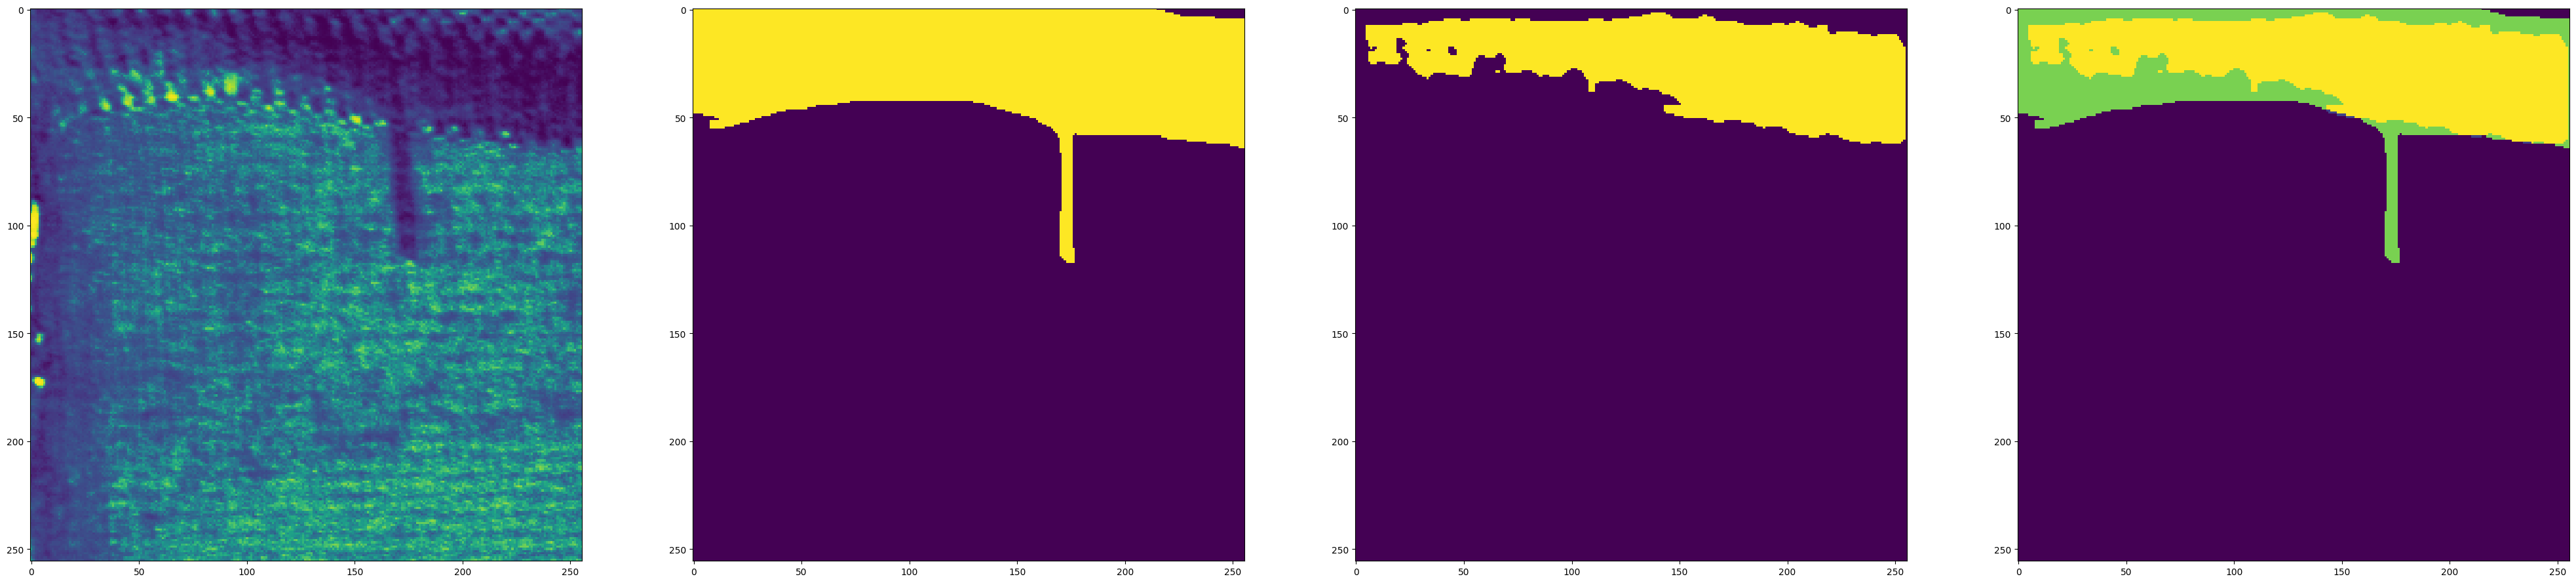

In [21]:
bn = 0
inputs = images[bn]
targets = gt[bn]
outputs = predictions[bn]

idx = 2
img = inputs[idx].reshape(256, 256)
og_mask = targets[idx].reshape(256, 256)

pred = outputs[idx].reshape(256, 256)
amin = np.amin(pred)
amax = np.amax(pred)
pred = (pred - amin) / (amax - amin)
_, thresh = cv2.threshold(pred, 0.75, 1, cv2.THRESH_BINARY)

overlay = cv2.addWeighted(og_mask,0.4,thresh,0.1,0)

fig, ax = plt.subplots(1, 4, figsize=(50,30))
ax[0].imshow(img)
ax[1].imshow(og_mask)
ax[2].imshow(thresh)
ax[3].imshow(overlay)


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [15]:
targets[0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

tensor(0.3702)